In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [1]:
from datasets import load_dataset

dataset_name = "dim/nfs_pix2pix_1920_1080_v5"
# dataset_name = "dim/nfs_pix2pix_1920_1080_v6"
dataset = load_dataset(dataset_name, num_proc=4)
dataset = dataset["train"]

In [4]:
dataset[0]["edit_prompt"]

'make nfs 2005 photorealistic'

In [ ]:
dataset[180]["edited_image"]

In [2]:
import os

# os.chdir("/code/img2img_turbo/src")
import argparse
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
import torchvision.transforms.functional as F
from img2img_turbo.src.pix2pix_turbo import Pix2Pix_Turbo
from img2img_turbo.src.image_prep import canny_from_pil
from img2img_turbo.src.benchmark import merge_loras

model_name = ""
model_path = "/code/img2img_turbo/models/model_20001.pkl"
use_fp16 = not False

# initialize the model
model = Pix2Pix_Turbo(pretrained_name=model_name, pretrained_path=model_path)
merge_loras(model=model)
model.set_eval()
# if use_fp16:
model.to(torch.bfloat16)
model.unet.to(torch.bfloat16)
model.vae.to(torch.bfloat16)

T = transforms.Compose(
    [
        transforms.Resize(512, interpolation=transforms.InterpolationMode.LANCZOS),
        transforms.CenterCrop(512),
    ]
)

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

/code/img2img_turbo/src/pix2pix_turbo.py:182: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(pretrained_path, map_location="cpu")


In [ ]:
model

In [8]:
model.timesteps = torch.tensor([999], device="cuda:0")

In [2]:
model.cache_prompts

{}

In [ ]:
import torch


In [27]:
F.to_tensor

<function torchvision.transforms.functional.to_tensor(pic) -> torch.Tensor>

In [ ]:
unet = UNet2DConditionModel.from_pretrained(
    "latent-consistency/lcm-sdxl",
    torch_dtype=torch.float16,
    variant="fp16",
)

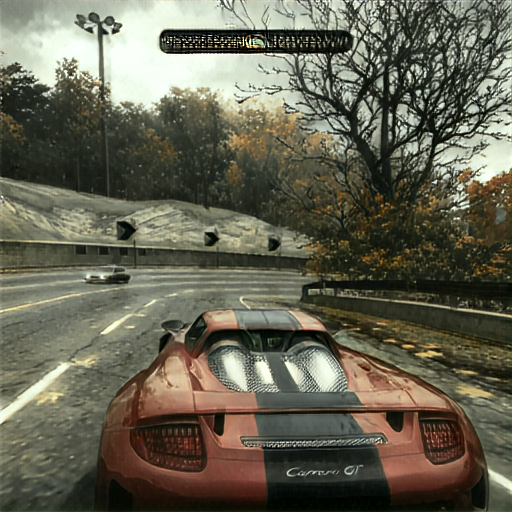

In [65]:
pos = 590
input_image = dataset[pos]["input_image"].convert("RGB")
prompt = dataset[0]["edit_prompt"]
with torch.no_grad():
    i_t = T(input_image)
    # i_t = input_image
    c_t = F.to_tensor(i_t).unsqueeze(0)
    # if use_fp16:
    c_t = c_t.to(torch.bfloat16).cuda()
    # output_image = model(c_t, prompt)
    output_image = model.custom_forward(c_t, prompt)

    output_pil = transforms.ToPILImage()(output_image[0].cpu() * 0.5 + 0.5)

output_pil

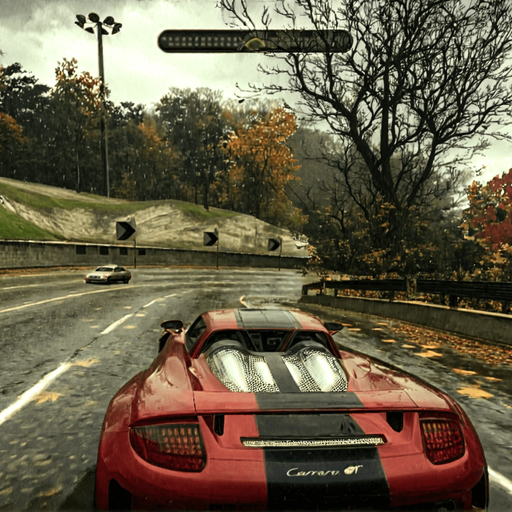

In [58]:
T(dataset[pos]["edited_image"].convert("RGB"))

In [ ]:
model

### Merge loras

In [6]:
model_modules = dict(model.named_modules())
for module_key in model_modules:
    if "base_layer" in module_key:
        # print(module_key)
        parent_module = ".".join(module_key.split(".")[:-1])
        prev_parent_module = ".".join(module_key.split(".")[:-2])
        if hasattr(model_modules[parent_module], "base_layer"):
            # print(parent_module)
            # print(prev_parent_module)
            model_modules[parent_module].merge()
            # model_modules[parent_module] = model_modules[module_key]
            # last =
            setattr(
                model_modules[prev_parent_module],
                parent_module.split(".")[-1],
                model_modules[module_key],
            )

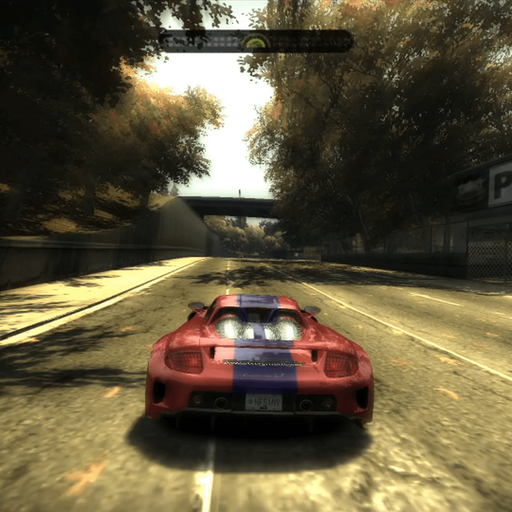

In [101]:
i_t

In [ ]:
# huggingface-cli upload dim/nfs_pix2pix_1736605715 /code/img2img-turbo/output/pix2pix_turbo/nfs_pix2pix_1736605715/checkpoints/model_20001.pkl model_20001.pkl